# Tracking Human Walking - Object Detection Module

## 0. Download Dataset

In this project, we use MOT17 (Multiple Object Tracking 17)

In [1]:
# Download dataset with wget
!wget https://motchallenge.net/data/MOT17.zip

--2024-03-23 22:03:59--  https://motchallenge.net/data/MOT17.zip
Resolving motchallenge.net (motchallenge.net)... 131.159.19.34, 2a09:80c0:18::1034
Connecting to motchallenge.net (motchallenge.net)|131.159.19.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5860214001 (5.5G) [application/zip]
Saving to: ‘MOT17.zip’

MOT17.zip           100%[===================>]   5.46G  12.8MB/s    in 6m 24s  

2024-03-23 22:10:25 (14.5 MB/s) - ‘MOT17.zip’ saved [5860214001/5860214001]



In [2]:
# Unzip dataset
%%time
!unzip -qq -a MOT17.zip

CPU times: user 285 ms, sys: 42.9 ms, total: 328 ms
Wall time: 57 s


## 1. Import Libraries

In [3]:
!pip install ultralytics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.9/722.9 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 93.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━

In [4]:
import pandas as pd
import os
import yaml
import shutil
import configparser
import ultralytics
ultralytics.checks() # Check if untralytics successfully installed or not

from tqdm import tqdm
from ultralytics import YOLO

Ultralytics YOLOv8.1.32 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 40.0/201.2 GB disk)


## 2. Data Preprocessing - Convert Dataset to YOLO Format

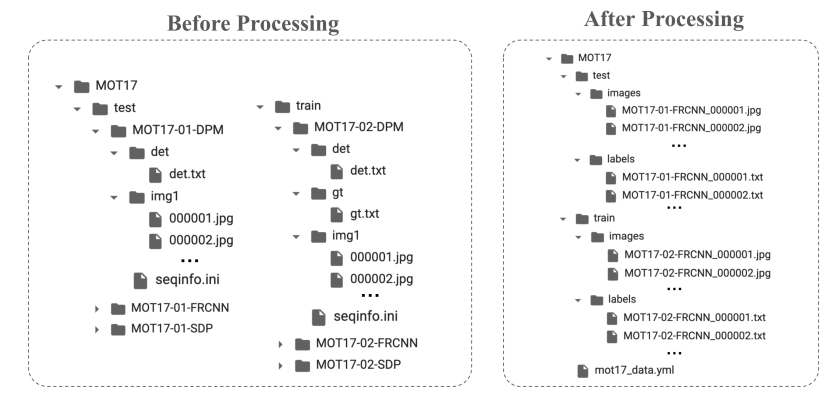

At the beginning, we have two main folders: `train` and `test`, which include subfolders corresponding to a tracking video that has been converted into image frames.

Each subfolder will have 3 versions corresponding to the results of 3 different models: DPM, FRCNN and SDP (the content of frames in the subfolders is the same, only different information in the det.txt file).

Information contained in each folder :
- det : contains `det.txt` file, which include information of `class` person in each frame
- gt : contains `gt.txt`, which contains ground truth (gt) information of each object in each frame
- img1 : contains images arranged in frame order
- seqinfo.ini : contains metadata about the image as shown below
```
[Sequence]
name=MOT17-02-DPM
imDir=imd1
frameRate=30
seqLength=600
imWidth=1920
imHeight=1080
imExt=.jpg
```
det.txt and gt.txt files have the following format
```
frame id bb_left bb_top bb_width bb_height confident class visibility
```

In this project, we only use `det.txt` file (only contains person `class`).

`gt.txt` file contains many others class and will increase the complexity of the project.

### Define normalize bounding box function
Convert boulding box (bb) information from `det.txt` file (bb_left, bb_top, bb_width, bb_height) to YOLO format (x_min, y_min, width, height) and then normalize to [0,1] range

In [5]:
def convert_to_yolo_format(bb, img_width, img_height):
    x_center = bb['bb_left'] + (bb['bb_width'] / 2)
    y_center = bb['bb_top'] + (bb['bb_height'] / 2)

    # Normalize the coordinates by the dimensions of the image
    x_center /= img_width
    y_center /= img_height
    bb_width_normalized = bb['bb_width'] / img_width
    bb_height_normalized = bb['bb_height'] / img_height

    # Clip the values to make sure they are between 0 and 1
    x_center = max(min(x_center, 1), 0)
    y_center = max(min(y_center, 1), 0)
    bb_width_normalized = max(min(bb_width_normalized, 1), 0)
    bb_height_normalized = max(min(bb_height_normalized, 1), 0)

    return (x_center, y_center, bb_width_normalized, bb_height_normalized)

### Define a function to get information from `seqinfo.ini` and `det.txt` files
Read the `seqinfo.ini` file and gets information about the image's width and height in subfolder.

Read the `det.txt` file and gets information about boulding box.

Finally, create a label_file to save information (Because YOLO's format requires each image_file to have a corresponding label_file)

In [6]:
def process_folder(folder_path):
    # Read image dimensions from seqinfo.ini
    config = configparser.ConfigParser()
    config.read(os.path.join(folder_path, 'seqinfo.ini'))
    img_width = int(config['Sequence']['imWidth'])
    img_height = int(config['Sequence']['imHeight'])

    # Load ground truth data
    gt_path = os.path.join(folder_path, 'det/det.txt')
    gt_data = pd.read_csv(
        gt_path,
        header=None,
        names=['frame', 'id', 'bb_left', 'bb_top', 'bb_width', 'bb_height', 'conf', 'class', 'visibility']
    )

    labels_folder = os.path.join(folder_path, 'labels')
    os.makedirs(labels_folder, exist_ok=True)

    for frame_number in gt_data['frame'].unique():
        frame_data = gt_data[gt_data['frame'] == frame_number]
        label_file = os.path.join(labels_folder, f'{frame_number:06d}.txt')

        with open(label_file, 'w') as file:
            for _, row in frame_data.iterrows():
                yolo_bb = convert_to_yolo_format(row, img_width, img_height)
                file.write(f'0 {yolo_bb[0]} {yolo_bb[1]} {yolo_bb[2]} {yolo_bb[3]}\n')

### Define a function to process whole dataset
Process all folder in 1 main folder (train/test). Note that we only use 1 among 3 version (FRCNN), the others will be removed.

In [7]:
def process_all_folders(base_directory):
    # List all subdirectories in the base directory
    for folder_name in tqdm(os.listdir(base_directory)):
        folder_path = os.path.join(base_directory, folder_name)

        # Delete folder not contain 'FRCNN' in name
        if 'FRCNN' not in folder_name:
            os.system(f'rm -rf {folder_path}')
            continue

        if os.path.isdir(folder_path):
            process_folder(folder_path)

### Data Processing

In [8]:
process_all_folders('MOT17/train')
process_all_folders('MOT17/test')

100%|██████████| 21/21 [00:11<00:00,  1.90it/s]


After processing, the result will be as shown below
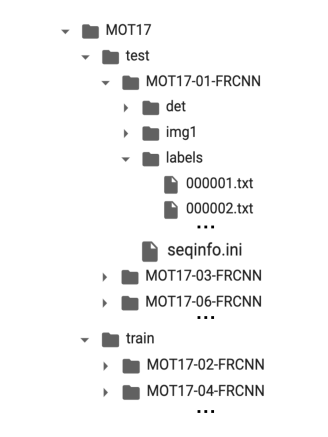

### Re-Structure dataset
Next step, move all image and label files from each subfolder of main folder (train and test) into only 1 unique folder. Delete all others subfolder.

#### Define move file function
Because the file names in each folder are the same (Starting from 000001.jpg). To be able to move into the same folder, we need to add the `folder_name` to the beginning of the `file_name` so that the files are not overridden

In [9]:
def rename_and_move_files(src_folder, dst_folder, folder_name, file_extension):
    for filename in os.listdir(src_folder):
        if filename.endswith(file_extension):
            # Include folder name in the new filename
            new_filename = f'{folder_name}_{filename}'
            shutil.move(os.path.join(src_folder, filename),
                        os.path.join(dst_folder, new_filename))

#### Define a function to move file from all folders
Next, define a function to move all files from subfolders in base_directory into 2 main folder `images` and `labels`.

For each subfolder, image files (.jpg) and label file (.txt) will be moved into new direction.

In [10]:
def move_files_all_folders(base_directory):
    images_dir = os.path.join(base_directory, 'images')
    labels_dir = os.path.join(base_directory, 'labels')
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)

    for folder_name in tqdm(os.listdir(base_directory)):
        if folder_name in ['images', 'labels']:  # Skip these folders
            continue

        folder_path = os.path.join(base_directory, folder_name)
        if os.path.isdir(folder_path):
            rename_and_move_files(os.path.join(folder_path, 'img1'), images_dir, folder_name, '.jpg')
            rename_and_move_files(os.path.join(folder_path, 'labels'), labels_dir, folder_name, '.txt')

In [11]:
move_files_all_folders('MOT17/train')
move_files_all_folders('MOT17/test')

100%|██████████| 9/9 [00:00<00:00, 23.45it/s]


#### Define function to delete subfolders
Next step, delete all subfolders in base_directory, except `images` and `labels`.

For each subfolder that is not 'images' or 'labels', `shutil.rmtree()` method is used to remove an entire directory tree rooted at a specified path, including all files and subdirectories within it.

In [12]:
def delete_subfolders(base_directory):
    for folder_name in os.listdir(base_directory):
        folder_path = os.path.join(base_directory, folder_name)
        if os.path.isdir(folder_path) and folder_name not in ['images', 'labels']:
            shutil.rmtree(folder_path)
            print(f"Deleted folder: {folder_name}")

#### Deleting subfolders

In [13]:
# Delete all subfolders except 'images' and 'labels'
delete_subfolders('MOT17/train')
delete_subfolders('MOT17/test')

Deleted folder: MOT17-09-FRCNN
Deleted folder: MOT17-05-FRCNN
Deleted folder: MOT17-13-FRCNN
Deleted folder: MOT17-02-FRCNN
Deleted folder: MOT17-04-FRCNN
Deleted folder: MOT17-11-FRCNN
Deleted folder: MOT17-10-FRCNN
Deleted folder: MOT17-07-FRCNN
Deleted folder: MOT17-01-FRCNN
Deleted folder: MOT17-14-FRCNN
Deleted folder: MOT17-12-FRCNN
Deleted folder: MOT17-08-FRCNN
Deleted folder: MOT17-03-FRCNN
Deleted folder: MOT17-06-FRCNN


### Setup YAML file
Setup YAML file which contains information about train/test folder and number of `class` of this project

In [14]:
class_labels = [
    'objects'
]
dataset_root_dir = os.path.join(
    os.getcwd(),
    'MOT17'
)
yolo_yaml_path = os.path.join(
    dataset_root_dir,
    'mot17_data.yml'
)

data_yaml = {
    'path': dataset_root_dir,
    'train': 'train/images',
    'val': 'test/images',
    'nc': len(class_labels),
    'names': class_labels
}

with open(yolo_yaml_path, 'w') as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

Final result

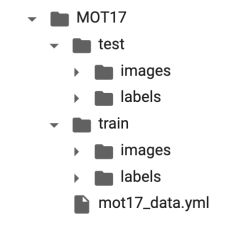

## 3. Setup Module Detector: YOLOv9

### Train YOLOv8 Model

In [15]:
# Load the YOLOv8 model
model = YOLO('yolov8s.pt')

# Config
epochs = 30
batch_size = -1 # Auto scale based on GPU memory
img_size = 640
project_name = 'models/yolo'
name = 'yolov8s_mot17_det'

# Train the model
results = model.train(
    data=yolo_yaml_path,
    epochs=epochs,
    batch=batch_size,
    imgsz=img_size,
    project=project_name,
    name=name
)

100%|██████████| 21.5M/21.5M [00:00<00:00, 338MB/s]


Ultralytics YOLOv8.1.32 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/MOT17/mot17_data.yml, epochs=30, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=models/yolo, name=yolov8s_mot17_det, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show

100%|██████████| 755k/755k [00:00<00:00, 119MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 256MB/s]


AMP: checks passed ✅
AutoBatch: Computing optimal batch size for imgsz=640
AutoBatch: CUDA:0 (NVIDIA A100-SXM4-40GB) 39.56G total, 0.25G reserved, 0.11G allocated, 39.20G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    11135987       28.65         0.480         25.91         74.38        (1, 3, 640, 640)                    list
    11135987       57.29         0.732          20.6         44.71        (2, 3, 640, 640)                    list
    11135987       114.6         1.074         20.23         46.07        (4, 3, 640, 640)                    list
    11135987       229.2         1.839         23.64         50.76        (8, 3, 640, 640)                    list
    11135987       458.4         3.620         25.06         54.05       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 112 for CUDA:0 23.85G/39.56G (60%) ✅


train: Scanning /content/MOT17/train/labels... 5316 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5316/5316 [00:04<00:00, 1300.71it/s]


train: New cache created: /content/MOT17/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/MOT17/test/labels... 5908 images, 11 backgrounds, 0 corrupt: 100%|██████████| 5919/5919 [00:05<00:00, 1008.33it/s]


val: New cache created: /content/MOT17/test/labels.cache
Plotting labels to models/yolo/yolov8s_mot17_det/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000875), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to models/yolo/yolov8s_mot17_det
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      29.4G      1.171     0.9264     0.9985       1303        640: 100%|██████████| 48/48 [00:37<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:29<00:00,  1.10s/it]


                   all       5919     110141      0.871      0.803      0.893      0.587

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      32.8G     0.9951     0.5935     0.9212       1188        640: 100%|██████████| 48/48 [00:27<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:25<00:00,  1.06it/s]


                   all       5919     110141      0.817      0.753      0.851      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30        31G     0.9694     0.5792     0.9209       1098        640: 100%|██████████| 48/48 [00:27<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:25<00:00,  1.04it/s]


                   all       5919     110141      0.826      0.743       0.83      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      31.7G     0.9463     0.5622      0.916       1246        640: 100%|██████████| 48/48 [00:27<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


                   all       5919     110141      0.862       0.79      0.873      0.548

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      27.8G      0.903     0.5247     0.9064       1102        640: 100%|██████████| 48/48 [00:26<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


                   all       5919     110141      0.889      0.815      0.902      0.598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30        28G     0.8573     0.4939     0.8936       1218        640: 100%|██████████| 48/48 [00:25<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:26<00:00,  1.01it/s]


                   all       5919     110141      0.885      0.805      0.896      0.601

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      29.1G     0.8292     0.4883     0.8884       1293        640: 100%|██████████| 48/48 [00:27<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:26<00:00,  1.03it/s]


                   all       5919     110141      0.872       0.81      0.897      0.578

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      29.8G     0.7922     0.4597     0.8787       1293        640: 100%|██████████| 48/48 [00:27<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:26<00:00,  1.03it/s]


                   all       5919     110141       0.89      0.815      0.899      0.598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      31.7G     0.7777     0.4532     0.8771       1293        640: 100%|██████████| 48/48 [00:26<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:25<00:00,  1.06it/s]


                   all       5919     110141       0.89      0.818      0.899      0.601

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30        31G     0.7736     0.4437     0.8735       1025        640: 100%|██████████| 48/48 [00:27<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


                   all       5919     110141      0.899      0.804      0.899      0.615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      29.1G     0.7442     0.4252     0.8677       1358        640: 100%|██████████| 48/48 [00:28<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:24<00:00,  1.10it/s]


                   all       5919     110141       0.89      0.825      0.911      0.632

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      29.6G     0.7324     0.4178     0.8641       1023        640: 100%|██████████| 48/48 [00:27<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:26<00:00,  1.03it/s]


                   all       5919     110141      0.897      0.802      0.897      0.629

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      29.4G     0.7172     0.4158     0.8618       1292        640: 100%|██████████| 48/48 [00:26<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


                   all       5919     110141      0.893      0.808        0.9      0.615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      30.6G     0.7042     0.4064     0.8608       1090        640: 100%|██████████| 48/48 [00:27<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:26<00:00,  1.04it/s]


                   all       5919     110141      0.897      0.824      0.906      0.618

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      28.5G     0.7032     0.3995     0.8585       1161        640: 100%|██████████| 48/48 [00:27<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:25<00:00,  1.06it/s]


                   all       5919     110141      0.893      0.804        0.9      0.625

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      28.2G     0.6839     0.3917     0.8577       1431        640: 100%|██████████| 48/48 [00:27<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:25<00:00,  1.06it/s]


                   all       5919     110141      0.892      0.817      0.908      0.636

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      29.5G     0.6795     0.3883      0.855       1242        640: 100%|██████████| 48/48 [00:28<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:25<00:00,  1.08it/s]


                   all       5919     110141      0.895      0.814      0.908      0.625

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      27.4G     0.6607     0.3734     0.8512       1120        640: 100%|██████████| 48/48 [00:27<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:26<00:00,  1.03it/s]


                   all       5919     110141       0.89      0.829       0.91       0.64

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      26.9G     0.6436     0.3686     0.8498       1128        640: 100%|██████████| 48/48 [00:26<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:26<00:00,  1.01it/s]

                   all       5919     110141      0.895      0.811      0.904      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      31.9G      0.642     0.3671     0.8492       1029        640: 100%|██████████| 48/48 [00:25<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


                   all       5919     110141        0.9      0.812      0.906      0.645
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      26.3G     0.6249     0.3595      0.836        745        640: 100%|██████████| 48/48 [00:36<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:25<00:00,  1.05it/s]


                   all       5919     110141      0.887       0.82      0.904      0.639

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      26.2G     0.6109     0.3486      0.832        610        640: 100%|██████████| 48/48 [00:25<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:26<00:00,  1.04it/s]


                   all       5919     110141       0.89      0.825      0.905      0.628

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      26.3G     0.5986      0.342     0.8298        544        640: 100%|██████████| 48/48 [00:25<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:25<00:00,  1.05it/s]


                   all       5919     110141      0.899      0.807        0.9      0.638

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      26.3G     0.5887     0.3353     0.8278        681        640: 100%|██████████| 48/48 [00:25<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:25<00:00,  1.05it/s]


                   all       5919     110141      0.904      0.807      0.901      0.639

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      26.2G     0.5733      0.327     0.8252        630        640: 100%|██████████| 48/48 [00:25<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:25<00:00,  1.04it/s]

                   all       5919     110141      0.905      0.803      0.901      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      26.4G     0.5602      0.317     0.8227        628        640: 100%|██████████| 48/48 [00:25<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:25<00:00,  1.05it/s]

                   all       5919     110141      0.902      0.797      0.897       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      26.2G     0.5526     0.3143     0.8204        663        640: 100%|██████████| 48/48 [00:26<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:24<00:00,  1.09it/s]


                   all       5919     110141      0.902      0.807      0.903      0.647

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      26.2G     0.5383     0.3059     0.8179        600        640: 100%|██████████| 48/48 [00:24<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:26<00:00,  1.03it/s]


                   all       5919     110141      0.902       0.81      0.903      0.652

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      26.4G     0.5286     0.2998     0.8166        622        640: 100%|██████████| 48/48 [00:25<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:24<00:00,  1.09it/s]


                   all       5919     110141      0.908        0.8      0.903      0.651

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      26.4G     0.5192     0.2948     0.8153        687        640: 100%|██████████| 48/48 [00:25<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:24<00:00,  1.09it/s]


                   all       5919     110141      0.904      0.812      0.909      0.653

30 epochs completed in 0.459 hours.
Optimizer stripped from models/yolo/yolov8s_mot17_det/weights/last.pt, 22.5MB
Optimizer stripped from models/yolo/yolov8s_mot17_det/weights/best.pt, 22.5MB

Validating models/yolo/yolov8s_mot17_det/weights/best.pt...
Ultralytics YOLOv8.1.32 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:45<00:00,  1.67s/it]


                   all       5919     110141      0.904      0.812      0.909      0.653
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to models/yolo/yolov8s_mot17_det


### Set up class Detector
With the YOLO model that has just been trained, we will build a Detector class for convenience in use.

This class receives as input parameter the model file path, and has a detect() method to perform detection for any image.

In [16]:
class YOLOv8:
  def __init__(self, model_path):
    self.model = YOLO(model_path)

  def detect(self, source_img):
    results = self.model.predict(source_img, verbose=False)[0]
    bboxes = results.boxes.xywh.cpu().numpy()
    bboxes[:, :2] = bboxes[:, :2] - (bboxes[:, 2:] / 2)
    scores = results.boxes.conf.cpu().numpy()
    classes = results.boxes.cls.cpu().numpy()

    return bboxes, scores, classes

## 4. Evaluation

In [17]:
# Load the trained model
model_path = os.path.join(
    project_name, name, 'weights/best.pt'
)
model = YOLO(model_path)

metrics = model.val(
    project=project_name,
    name='detect/val'
)

Ultralytics YOLOv8.1.32 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/MOT17/test/labels.cache... 5908 images, 11 backgrounds, 0 corrupt: 100%|██████████| 5919/5919 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 370/370 [00:51<00:00,  7.21it/s]


                   all       5919     110141      0.904      0.812      0.909      0.654
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to models/yolo/detect/val


## 5. Inference

In [18]:
sample_path = 'MOT17/test/images/MOT17-01-FRCNN_000001.jpg'
results = model.predict(
    sample_path,
    project=project_name,
    name='detect/predict',
    save=True
)


image 1/1 /content/MOT17/test/images/MOT17-01-FRCNN_000001.jpg: 384x640 9 objectss, 173.6ms
Speed: 2.4ms preprocess, 173.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
Results saved to models/yolo/detect/predict
